# Model Testing on Preprocessed UNSW-NB15 Data 

<li> UNSW-NB15 is a dataset created by cyber security research group at the “Australian Centre for Cyber Security” using IXIA PerfectStorm tool in the Cyber Range Lab of The University of New South Wales, Canberra. It was created for research on role Machine Learning can have in Intrusion Detection Systems. </li>
<li> All the models in this notebook are being trained to detect Normal network traffic(0) or attack traffic(1).  </li>

In [1]:
# Importing Required Libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve,roc_auc_score,f1_score
import pandas as pd
from multiprocessing import Process# this is used for multithreading
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from scipy.sparse import hstack
import pickle

## 1. Reading Data and Train, Validation and Test Split

In [2]:
# Reading Preprocessed data obratained in EDA file

# Since we have 2.5 million rows with 47 features for each datapoint.
# Due to computational limitations, 1 million rows were selected
data = pd.read_csv("final_data.csv",nrows=1000000)
data.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label,source_avg_pkt,dst_pkt_size,vr_source_avg_pkt,vr_dst_avg_pkt
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,3,1,1,2,normal,0,132.0,76.0,0.0,0.0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,2,2,1,1,normal,0,73.0,89.0,0.0,0.0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,1,1,1,1,normal,0,66.0,82.0,0.0,0.0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,1,1,1,1,normal,0,73.0,89.0,0.0,0.0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,3,1,1,2,normal,0,142.0,78.0,0.0,0.0


In [4]:
# Separating Class labels and Features

x = data.drop(['Label','attack_cat'],axis=1)
y = data['Label']

In [5]:
# split the data into test and train by maintaining same distribution of output varaible 'y'
X_train, X_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.20)


# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train'
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [6]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 640000
Number of data points in test data: 200000
Number of data points in cross validation data: 160000


In [7]:
train_class_distribution = y_train.value_counts()
print("Number of points in train data for each Class are as follows: \n")
print(train_class_distribution)

test_class_distribution = y_test.value_counts()
print("Number of points in test data for each Class are as follows: \n")
print(test_class_distribution)

Number of points in train data for each Class are as follows: 

0    633833
1      6167
Name: Label, dtype: int64
Number of points in test data for each Class are as follows: 

0    198073
1      1927
Name: Label, dtype: int64


In [21]:
# Preprocessing all the variables


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

scaler = StandardScaler()                              # Scalar object for numerical features
onehotencoder = OneHotEncoder(handle_unknown='ignore') # OneHotEncoder for categorical features.


# Categorical Features

proto_train = onehotencoder.fit_transform(X_train['proto'].values.reshape(-1,1))
proto_cv = onehotencoder.transform(X_cv['proto'].values.reshape(-1,1))
proto_test = onehotencoder.transform(X_test['proto'].values.reshape(-1,1))


state_train = onehotencoder.fit_transform(X_train['state'].values.reshape(-1,1))
state_cv = onehotencoder.transform(X_cv['state'].values.reshape(-1,1))
state_test = onehotencoder.transform(X_test['state'].values.reshape(-1,1))

service_train = onehotencoder.fit_transform(X_train['service'].values.reshape(-1,1))
service_cv = onehotencoder.transform(X_cv['service'].values.reshape(-1,1))
service_test = onehotencoder.transform(X_test['service'].values.reshape(-1,1))

is_sm_ips_ports_train = onehotencoder.fit_transform(X_train['is_sm_ips_ports'].values.reshape(-1,1))
is_sm_ips_ports_cv = onehotencoder.transform(X_cv['is_sm_ips_ports'].values.reshape(-1,1))
is_sm_ips_ports_test = onehotencoder.transform(X_test['is_sm_ips_ports'].values.reshape(-1,1))

ct_state_ttl_train = onehotencoder.fit_transform(X_train['ct_state_ttl'].values.reshape(-1,1))
ct_state_ttl_cv = onehotencoder.transform(X_cv['ct_state_ttl'].values.reshape(-1,1))
ct_state_ttl_test = onehotencoder.transform(X_test['ct_state_ttl'].values.reshape(-1,1))


# Numerical Features

sport_train = scaler.fit_transform(X_train['sport'].values.reshape(-1,1))
sport_cv = scaler.transform(X_cv['sport'].values.reshape(-1,1))
sport_test = scaler.transform(X_test['sport'].values.reshape(-1,1))

dsport_train = scaler.fit_transform(X_train['dsport'].values.reshape(-1,1))
dsport_cv = scaler.transform(X_cv['dsport'].values.reshape(-1,1))
dsport_test = scaler.transform(X_test['dsport'].values.reshape(-1,1))

dur_train = scaler.fit_transform(X_train['dur'].values.reshape(-1,1))
dur_cv = scaler.transform(X_cv['dur'].values.reshape(-1,1))
dur_test = scaler.transform(X_test['dur'].values.reshape(-1,1))

sbytes_train = scaler.fit_transform(X_train['sbytes'].values.reshape(-1,1))
sbytes_cv = scaler.transform(X_cv['sbytes'].values.reshape(-1,1))
sbytes_test = scaler.transform(X_test['sbytes'].values.reshape(-1,1))

dbytes_train = scaler.fit_transform(X_train['dbytes'].values.reshape(-1,1))
dbytes_cv = scaler.transform(X_cv['dbytes'].values.reshape(-1,1))
dbytes_test = scaler.transform(X_test['dbytes'].values.reshape(-1,1))

sttl_train = scaler.fit_transform(X_train['sttl'].values.reshape(-1,1))
sttl_cv = scaler.transform(X_cv['sttl'].values.reshape(-1,1))
sttl_test = scaler.transform(X_test['sttl'].values.reshape(-1,1))

dttl_train = scaler.fit_transform(X_train['dttl'].values.reshape(-1,1))
dttl_cv = scaler.transform(X_cv['dttl'].values.reshape(-1,1))
dttl_test = scaler.transform(X_test['dttl'].values.reshape(-1,1))

sloss_train = scaler.fit_transform(X_train['sloss'].values.reshape(-1,1))
sloss_cv = scaler.transform(X_cv['sloss'].values.reshape(-1,1))
sloss_test = scaler.transform(X_test['sloss'].values.reshape(-1,1))

dloss_train = scaler.fit_transform(X_train['dloss'].values.reshape(-1,1))
dloss_cv = scaler.transform(X_cv['dloss'].values.reshape(-1,1))
dloss_test = scaler.transform(X_test['dloss'].values.reshape(-1,1))

Sload_train = scaler.fit_transform(X_train['Sload'].values.reshape(-1,1))
Sload_cv = scaler.transform(X_cv['Sload'].values.reshape(-1,1))
Sload_test = scaler.transform(X_test['Sload'].values.reshape(-1,1))

Dload_train = scaler.fit_transform(X_train['Dload'].values.reshape(-1,1))
Dload_cv = scaler.transform(X_cv['Dload'].values.reshape(-1,1))
Dload_test = scaler.transform(X_test['Dload'].values.reshape(-1,1))

Spkts_train = scaler.fit_transform(X_train['Spkts'].values.reshape(-1,1))
Spkts_cv = scaler.transform(X_cv['Spkts'].values.reshape(-1,1))
Spkts_test = scaler.transform(X_test['Spkts'].values.reshape(-1,1))

Dpkts_train = scaler.fit_transform(X_train['Dpkts'].values.reshape(-1,1))
Dpkts_cv = scaler.transform(X_cv['Dpkts'].values.reshape(-1,1))
Dpkts_test = scaler.transform(X_test['Dpkts'].values.reshape(-1,1))

swin_train = scaler.fit_transform(X_train['swin'].values.reshape(-1,1))
swin_cv = scaler.transform(X_cv['swin'].values.reshape(-1,1))
swin_test = scaler.transform(X_test['swin'].values.reshape(-1,1))

dwin_train = scaler.fit_transform(X_train['dwin'].values.reshape(-1,1))
dwin_cv = scaler.transform(X_cv['dwin'].values.reshape(-1,1))
dwin_test = scaler.transform(X_test['dwin'].values.reshape(-1,1))

stcpb_train = scaler.fit_transform(X_train['stcpb'].values.reshape(-1,1))
stcpb_cv = scaler.transform(X_cv['stcpb'].values.reshape(-1,1))
stcpb_test = scaler.transform(X_test['stcpb'].values.reshape(-1,1))

dtcpb_train = scaler.fit_transform(X_train['dtcpb'].values.reshape(-1,1))
dtcpb_cv = scaler.transform(X_cv['dtcpb'].values.reshape(-1,1))
dtcpb_test = scaler.transform(X_test['dtcpb'].values.reshape(-1,1))

smeansz_train = scaler.fit_transform(X_train['smeansz'].values.reshape(-1,1))
smeansz_cv = scaler.transform(X_cv['smeansz'].values.reshape(-1,1))
smeansz_test = scaler.transform(X_test['smeansz'].values.reshape(-1,1))

dmeansz_train = scaler.fit_transform(X_train['dmeansz'].values.reshape(-1,1))
dmeansz_cv = scaler.transform(X_cv['dmeansz'].values.reshape(-1,1))
dmeansz_test = scaler.transform(X_test['dmeansz'].values.reshape(-1,1))

trans_depth_train = scaler.fit_transform(X_train['trans_depth'].values.reshape(-1,1))
trans_depth_cv = scaler.transform(X_cv['trans_depth'].values.reshape(-1,1))
trans_depth_test = scaler.transform(X_test['trans_depth'].values.reshape(-1,1))

res_bdy_len_train = scaler.fit_transform(X_train['res_bdy_len'].values.reshape(-1,1))
res_bdy_len_cv = scaler.transform(X_cv['res_bdy_len'].values.reshape(-1,1))
res_bdy_len_test = scaler.transform(X_test['res_bdy_len'].values.reshape(-1,1))

Sjit_train = scaler.fit_transform(X_train['Sjit'].values.reshape(-1,1))
Sjit_cv = scaler.transform(X_cv['Sjit'].values.reshape(-1,1))
Sjit_test = scaler.transform(X_test['Sjit'].values.reshape(-1,1))

Djit_train = scaler.fit_transform(X_train['Djit'].values.reshape(-1,1))
Djit_cv = scaler.transform(X_cv['Djit'].values.reshape(-1,1))
Djit_test = scaler.transform(X_test['Djit'].values.reshape(-1,1))

Sintpkt_train = scaler.fit_transform(X_train['Sintpkt'].values.reshape(-1,1))
Sintpkt_cv = scaler.transform(X_cv['Sintpkt'].values.reshape(-1,1))
Sintpkt_test = scaler.transform(X_test['Sintpkt'].values.reshape(-1,1))

Dintpkt_train = scaler.fit_transform(X_train['Dintpkt'].values.reshape(-1,1))
Dintpkt_cv = scaler.transform(X_cv['Dintpkt'].values.reshape(-1,1))
Dintpkt_test = scaler.transform(X_test['Dintpkt'].values.reshape(-1,1))

tcprtt_train = scaler.fit_transform(X_train['tcprtt'].values.reshape(-1,1))
tcprtt_cv = scaler.transform(X_cv['tcprtt'].values.reshape(-1,1))
tcprtt_test = scaler.transform(X_test['tcprtt'].values.reshape(-1,1))

synack_train = scaler.fit_transform(X_train['synack'].values.reshape(-1,1))
synack_cv = scaler.transform(X_cv['synack'].values.reshape(-1,1))
synack_test = scaler.transform(X_test['synack'].values.reshape(-1,1))

ackdat_train = scaler.fit_transform(X_train['ackdat'].values.reshape(-1,1))
ackdat_cv = scaler.transform(X_cv['ackdat'].values.reshape(-1,1))
ackdat_test = scaler.transform(X_test['ackdat'].values.reshape(-1,1))

ct_srv_src_train = scaler.fit_transform(X_train['ct_srv_src'].values.reshape(-1,1))
ct_srv_src_cv = scaler.transform(X_cv['ct_srv_src'].values.reshape(-1,1))
ct_srv_src_test = scaler.transform(X_test['ct_srv_src'].values.reshape(-1,1))

ct_srv_dst_train = scaler.fit_transform(X_train['ct_srv_dst'].values.reshape(-1,1))
ct_srv_dst_cv = scaler.transform(X_cv['ct_srv_dst'].values.reshape(-1,1))
ct_srv_dst_test = scaler.transform(X_test['ct_srv_dst'].values.reshape(-1,1))

ct_dst_ltm_train = scaler.fit_transform(X_train['ct_dst_ltm'].values.reshape(-1,1))
ct_dst_ltm_cv = scaler.transform(X_cv['ct_dst_ltm'].values.reshape(-1,1))
ct_dst_ltm_test = scaler.transform(X_test['ct_dst_ltm'].values.reshape(-1,1))

ct_src_ltm_train = scaler.fit_transform(X_train['ct_src_ltm'].values.reshape(-1,1))
ct_src_ltm_cv = scaler.transform(X_cv['ct_src_ltm'].values.reshape(-1,1))
ct_src_ltm_test = scaler.transform(X_test['ct_src_ltm'].values.reshape(-1,1))

ct_src_dport_ltm_train = scaler.fit_transform(X_train['ct_src_dport_ltm'].values.reshape(-1,1))
ct_src_dport_ltm_cv = scaler.transform(X_cv['ct_src_dport_ltm'].values.reshape(-1,1))
ct_src_dport_ltm_test = scaler.transform(X_test['ct_src_dport_ltm'].values.reshape(-1,1))

ct_dst_sport_ltm_train = scaler.fit_transform(X_train['ct_dst_sport_ltm'].values.reshape(-1,1))
ct_dst_sport_ltm_cv = scaler.transform(X_cv['ct_dst_sport_ltm'].values.reshape(-1,1))
ct_dst_sport_ltm_test = scaler.transform(X_test['ct_dst_sport_ltm'].values.reshape(-1,1))


# stacking all the obtained features and creating fina train , validation and test data.

X_train = hstack((proto_train,state_train,service_train,is_sm_ips_ports_train,ct_state_ttl_train,
                        sport_train,dsport_train,dur_train,sbytes_train,dbytes_train,sttl_train,dttl_train,
                        sloss_train,dloss_train,Sload_train,Dload_train,Spkts_train,Dpkts_train,swin_train,
                        dwin_train,stcpb_train,dtcpb_train,smeansz_train,dmeansz_train,trans_depth_train,
                        res_bdy_len_train,Sjit_train,Djit_train,Sintpkt_train,Dintpkt_train,
                        tcprtt_train,synack_train,ackdat_train,ct_srv_src_train,ct_srv_dst_train,ct_dst_ltm_train,
                        ct_src_ltm_train,ct_src_ltm_train,ct_src_dport_ltm_train,ct_dst_sport_ltm_train)).tocsr()


X_cv = hstack((proto_cv,state_cv,service_cv,is_sm_ips_ports_cv,ct_state_ttl_cv,
                        sport_cv,dsport_cv,dur_cv,sbytes_cv,dbytes_cv,sttl_cv,dttl_cv,
                        sloss_cv,dloss_cv,Sload_cv,Dload_cv,Spkts_cv,Dpkts_cv,swin_cv,
                        dwin_cv,stcpb_cv,dtcpb_cv,smeansz_cv,dmeansz_cv,trans_depth_cv,
                        res_bdy_len_cv,Sjit_cv,Djit_cv,Sintpkt_cv,Dintpkt_cv,
                        tcprtt_cv,synack_cv,ackdat_cv,ct_srv_src_cv,ct_srv_dst_cv,ct_dst_ltm_cv,
                        ct_src_ltm_cv,ct_src_ltm_cv,ct_src_dport_ltm_cv,ct_dst_sport_ltm_cv)).tocsr()


X_test = hstack((proto_test,state_test,service_test,is_sm_ips_ports_test,ct_state_ttl_test,
                        sport_test,dsport_test,dur_test,sbytes_test,dbytes_test,sttl_test,dttl_test,
                        sloss_test,dloss_test,Sload_test,Dload_test,Spkts_test,Dpkts_test,swin_test,
                        dwin_test,stcpb_test,dtcpb_test,smeansz_test,dmeansz_test,trans_depth_test,
                        res_bdy_len_test,Sjit_test,Djit_test,Sintpkt_test,Dintpkt_test,
                        tcprtt_test,synack_test,ackdat_test,ct_srv_src_test,ct_srv_dst_test,ct_dst_ltm_test,
                        ct_src_ltm_test,ct_src_ltm_test,ct_src_dport_ltm_test,ct_dst_sport_ltm_test)).tocsr()

In [22]:
# Function to plot confusion matrix.
# Reffered this function from Malware Detection assignment

def plot_confusion_matrix(test_y, predict_y):
    
    # Getting Confusion matrix
    C = confusion_matrix(test_y, predict_y)
    
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    # Recall Matrix from confusion matrix
    A =(((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix from confusion matrix
    B =(C/C.sum(axis=0))
    
    
    # Plotting Confusion, Precision and Recall matrix.
    labels = [0,1]
    cmap=sns.light_palette("green")
    
    
    print("-"*50, "Confusion matrix", "-"*50)
    %matplotlib inline
    plt.figure(figsize=(6,4))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*50, "Precision matrix", "-"*50)
    %matplotlib inline
    plt.figure(figsize=(6,4))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing A in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    %matplotlib inline
    plt.figure(figsize=(6,4))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [23]:
# AUC SCore is chosen as a metric because of imbalanced data
# Thus this function will plot ROC curve and return AUC score

def performance_metric(test_y,predict_y,plot_name):
    fpr, tpr, thresholds = roc_curve(test_y, predict_y)
    %matplotlib inline
    plt.plot(fpr,tpr)
    plt.title("{} ROC Curve".format(plot_name))
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")
    plt.show()
    
    return roc_auc_score(test_y,predict_y)

## 2. Machine Learning Models

### All the models will be trained in this section. At the end of this section, parameters related each are tabulated and Conclusions are made from that tabulated data

### 2.1 Random Model

<li> Random Model is chosen as a Baseline model to compare with </li>

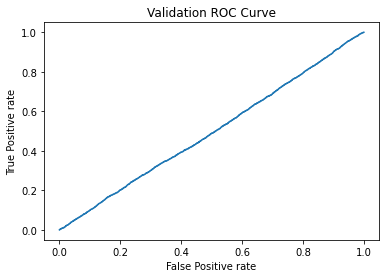

AUC Score on Cross Validation Data using Random Model :  0.4961174177506783


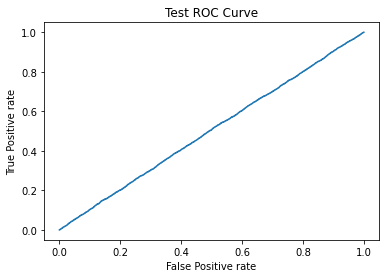

AUC Score on Test Data using Random Model :  0.50347711871395


Test Confusion, Recall and Precision Matrix will be as follows : 

Number of misclassified points  49.952000000000005
-------------------------------------------------- Confusion matrix --------------------------------------------------


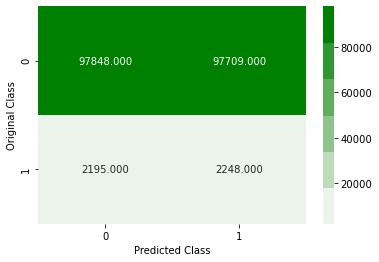

-------------------------------------------------- Precision matrix --------------------------------------------------


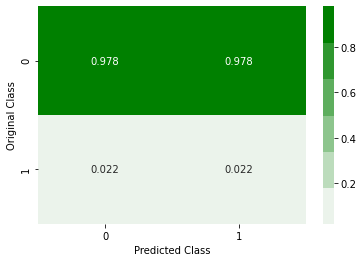

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


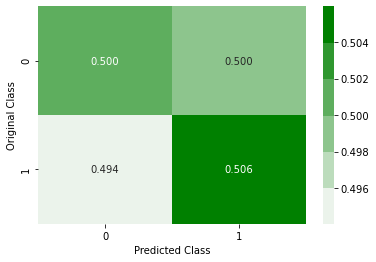

Sum of rows in precision matrix [1. 1.]


In [10]:
# Referred Microsoft Malware detection assignment for this and the cells with the models in futher part of this notebook.

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0] 
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,2))
for i in range(cv_data_len):
    cv_predicted_y[i][0] = np.random.uniform(0,1)
    cv_predicted_y[i][1] = 1 - cv_predicted_y[i][0]

print("AUC Score on Cross Validation Data using Random Model : ",performance_metric(y_cv,cv_predicted_y[:,1],"Validation"))


#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,2))
for i in range(test_data_len):
    test_predicted_y[i][0] = np.random.uniform(0,1)
    test_predicted_y[i][1] = 1 - test_predicted_y[i][0]
print("AUC Score on Test Data using Random Model : ",performance_metric(y_test,test_predicted_y[:,1],"Test"))

predicted_y =np.argmax(test_predicted_y, axis=1)
print("\n\nTest Confusion, Recall and Precision Matrix will be as follows : \n")
plot_confusion_matrix(y_test, predicted_y)

### 2.2 Logistic Regression

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.87s/it]

AUC Score for C =  0.01 is 0.9989083110016239
AUC Score for C =  0.1 is 0.999448696057635
AUC Score for C =  1 is 0.9994903626430679


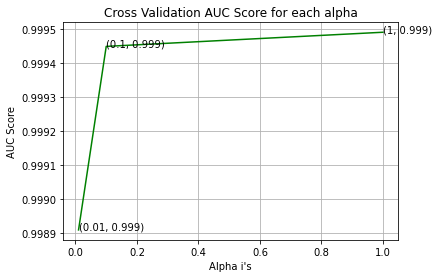

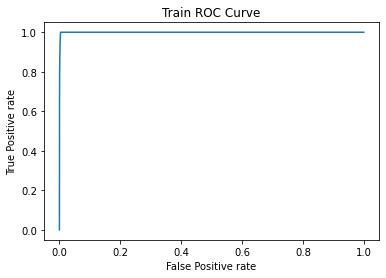

For values of best C =  1 The Train AUC Score is: 0.9994895397428745


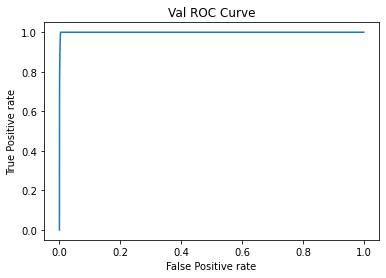

For values of best C =  1 The Validation AUC Score is: 0.9994903626430679


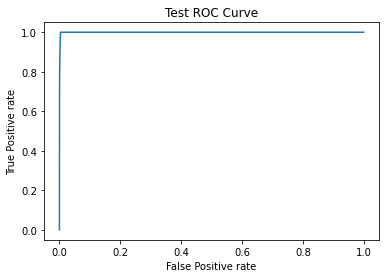

For values of best C =  1 The Test AUC Score is: 0.9994589264844425


Test Confusion, Recall and Precision Matrix will be as follows : 

Number of misclassified points  0.3505
-------------------------------------------------- Confusion matrix --------------------------------------------------


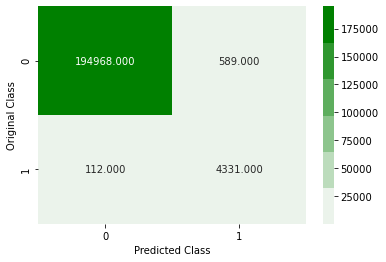

-------------------------------------------------- Precision matrix --------------------------------------------------


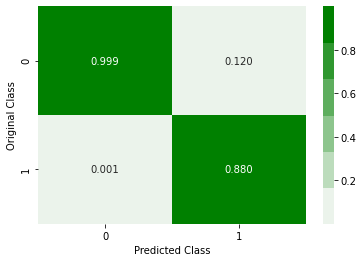

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


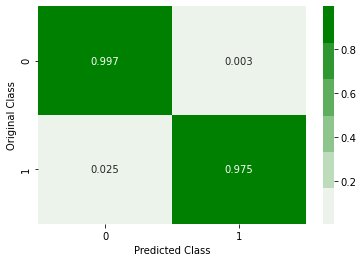

Sum of rows in precision matrix [1. 1.]


In [11]:
# Referred Microsoft Malware detection assignment for this code


# Hyperparameter values for tuning
alpha = [10 ** x for x in range(-2, 1)]

cv_auc_array=[]

for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))

# Printing Performance metric for each value of hyperparameter
for i in range(len(cv_auc_array)):
    print ('AUC Score for C = ',alpha[i],'is',cv_auc_array[i])

# finding best value of hyperparameter based on performance metric.
best_alpha = np.argmax(cv_auc_array)

    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC Score")
plt.show()


# Retraining model with Best hyperparameter value
logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)
 

# Plotting AUC for train, validation and Test data
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best C = ', alpha[best_alpha],
       "The Train AUC Score is:",performance_metric(y_train, predict_y[:,1],"Train"))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best C = ', alpha[best_alpha],
      "The Validation AUC Score is:",performance_metric(y_cv, predict_y[:,1],"Val"))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best C = ', alpha[best_alpha],
      "The Test AUC Score is:",performance_metric(y_test, predict_y[:,1],"Test"))


# Plotting Confusion Matrix
predicted_y =np.argmax(predict_y, axis=1)
print("\n\nTest Confusion, Recall and Precision Matrix will be as follows : \n")
plot_confusion_matrix(y_test, predicted_y)

### 2.3 Random Forest Classifier

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:46<00:00, 75.63s/it]

AUC Score for n_estimators =  10 is 0.9998616947056931
AUC Score for n_estimators =  50 is 0.9998721091038866
AUC Score for n_estimators =  100 is 0.9998729103497884


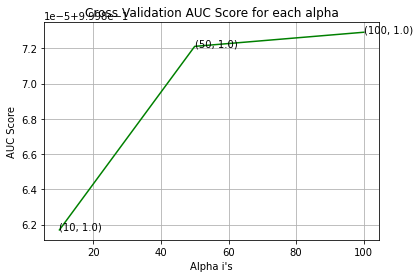

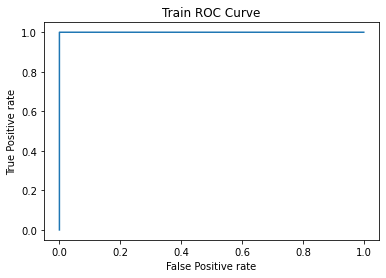

For values of best n_estimators =  100 The Train AUC Score is: 1.0


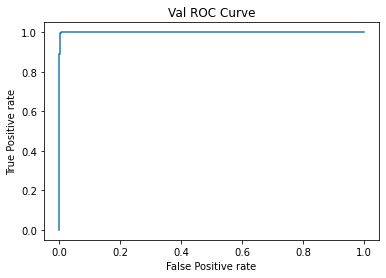

For values of best n_estimators =  100 The Validation AUC Score is: 0.9998729103497884


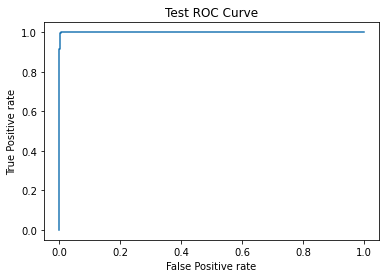

For values of best n_estimators =  100 The Test AUC Score is: 0.9998983299664896


Test Confusion, Recall and Precision Matrix will be as follows : 

Number of misclassified points  0.1735
-------------------------------------------------- Confusion matrix --------------------------------------------------


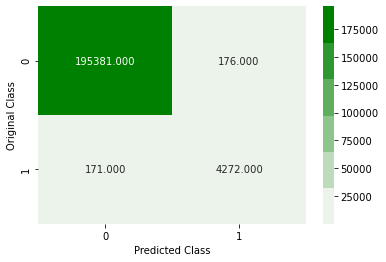

-------------------------------------------------- Precision matrix --------------------------------------------------


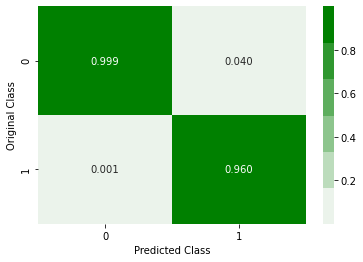

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


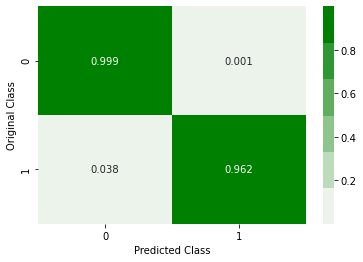

Sum of rows in precision matrix [1. 1.]


In [12]:
# Referred Microsoft Malware detection assignment for this code

# Hyperparameter values for tuning
alpha=[10,50,100]

cv_auc_array=[]

for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))

# Printing Performance metric for each value of hyperparameter
for i in range(len(cv_auc_array)):
    print ('AUC Score for n_estimators = ',alpha[i],'is',cv_auc_array[i])

    
# finding best value of hyperparameter based on performance metric.
best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC Score")
plt.show()


# Retraining model with Best hyperparameter value
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
 

# Plotting AUC for train, validation and Test data
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best n_estimators = ', alpha[best_alpha],
       "The Train AUC Score is:",performance_metric(y_train, predict_y[:,1],"Train"))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Validation AUC Score is:",performance_metric(y_cv, predict_y[:,1],"Val"))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Test AUC Score is:",performance_metric(y_test, predict_y[:,1],"Test"))


# Plotting Confusion Matrix
predicted_y =np.argmax(predict_y, axis=1)
print("\n\nTest Confusion, Recall and Precision Matrix will be as follows : \n")
plot_confusion_matrix(y_test, predicted_y)

### 2.4 XgBoost Classifier

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:38<00:00, 72.94s/it]

AUC Score for n_estimators =  10 is 0.9998181072883334
AUC Score for n_estimators =  50 is 0.999883077449864
AUC Score for n_estimators =  100 is 0.9998978523883254


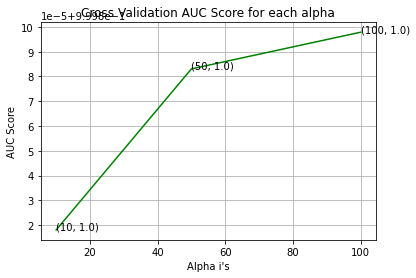

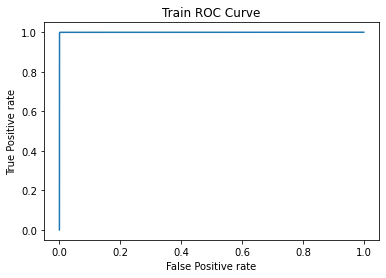

For values of best n_estimators =  100 The Train AUC Score is: 0.9999947086039961


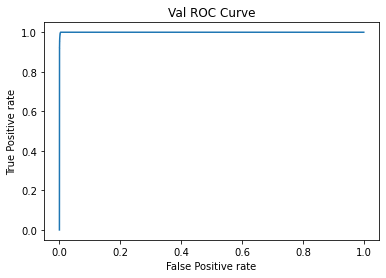

For values of best n_estimators =  100 The Validation AUC Score is: 0.9998978523883254


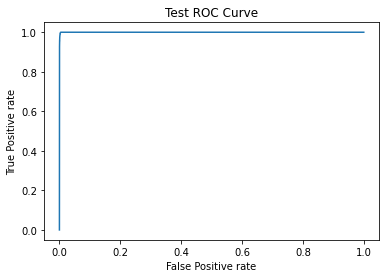

For values of best n_estimators =  100 The Test AUC Score is: 0.999907101232498


Test Confusion, Recall and Precision Matrix will be as follows : 

Number of misclassified points  0.1665
-------------------------------------------------- Confusion matrix --------------------------------------------------


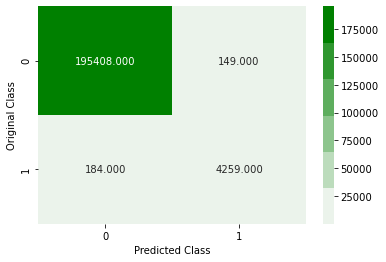

-------------------------------------------------- Precision matrix --------------------------------------------------


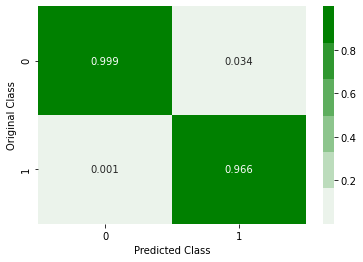

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


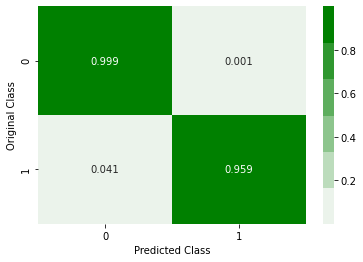

Sum of rows in precision matrix [1. 1.]


In [13]:
# Referred Microsoft Malware detection assignment for this code


# Hyperparameter values for tuning
alpha=[10,50,100]
cv_auc_array=[]


for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,eval_metric='merror')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))

# Printing Performance metric for each value of hyperparameter
for i in range(len(cv_auc_array)):
    print ('AUC Score for n_estimators = ',alpha[i],'is',cv_auc_array[i])

# finding best value of hyperparameter based on performance metric.
best_alpha = np.argmax(cv_auc_array)
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC Score")
plt.show()


# Retraining model with Best hyperparameter value
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],eval_metric='merror')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)


# Plotting AUC for train, validation and Test data 
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best n_estimators = ', alpha[best_alpha],
       "The Train AUC Score is:",performance_metric(y_train, predict_y[:,1],"Train"))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Validation AUC Score is:",performance_metric(y_cv, predict_y[:,1],"Val"))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Test AUC Score is:",performance_metric(y_test, predict_y[:,1],"Test"))



# Plotting Confusion Matrix
predicted_y =np.argmax(predict_y, axis=1)
print("\n\nTest Confusion, Recall and Precision Matrix will be as follows : \n")
plot_confusion_matrix(y_test, predicted_y)

### 2.5 XGBoost With Oversampling of Minority class

#### 2.5.1 Oversampling

In [14]:
# Referred below blog to implement Oversampling of minority class
# https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

import imblearn
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)
print("Shape of data before Sampling : ",X_train.shape)
print("Number of Positive points before sampling : ",np.count_nonzero(y_train))
print("Number of Negative points before sampling : ",len(y_over)-np.count_nonzero(y_over))

print("\n\nShape of data after Sampling  : ",X_over.shape)
print("Number of Positive points After sampling : ",np.count_nonzero(y_over))
print("Number of Negative points before sampling : ",len(y_over)-np.count_nonzero(y_over))

Shape of data before Sampling :  (640000, 203)
Number of Positive points before sampling :  14218
Number of Negative points before sampling :  625782


Shape of data after Sampling  :  (1251564, 203)
Number of Positive points After sampling :  625782
Number of Negative points before sampling :  625782


<li> It can be noticed that the number of datapoints in minority and majority class are equal after sampling. </li>

#### 2.5.2 Training XGBoost Model

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:17<00:00, 145.85s/it]

AUC Score for n_estimators =  10 is 0.9997659777443492
AUC Score for n_estimators =  50 is 0.9998710102009772
AUC Score for n_estimators =  100 is 0.999888229344109


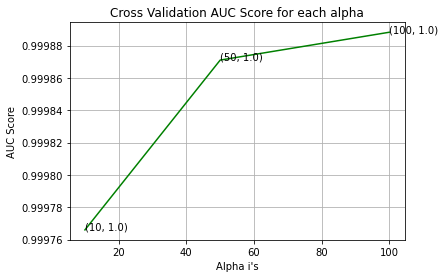

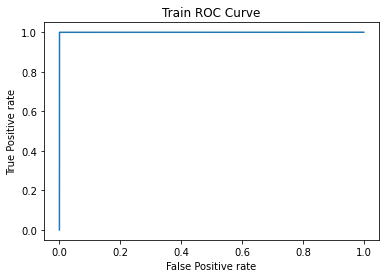

For values of best n_estimators =  100 The Train AUC Score is: 0.999995615220376


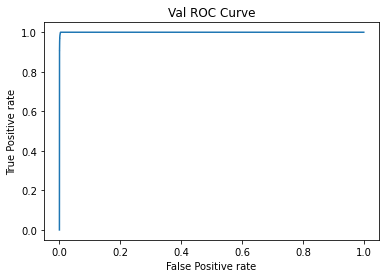

For values of best n_estimators =  100 The Validation AUC Score is: 0.999888229344109


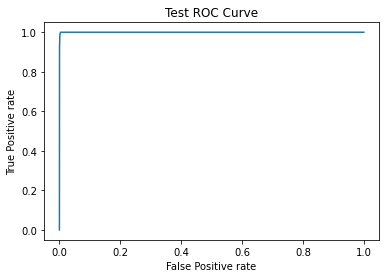

For values of best n_estimators =  100 The Test AUC Score is: 0.9998982603349985


Test Confusion, Recall and Precision Matrix will be as follows : 

Number of misclassified points  0.185
-------------------------------------------------- Confusion matrix --------------------------------------------------


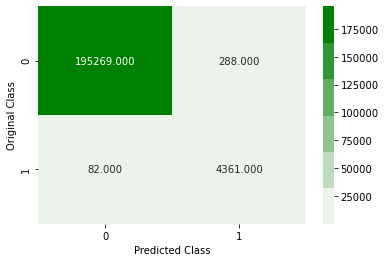

-------------------------------------------------- Precision matrix --------------------------------------------------


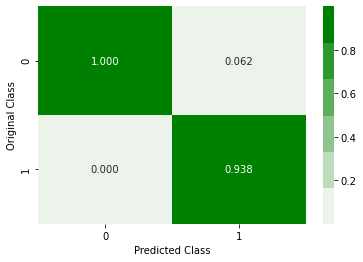

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


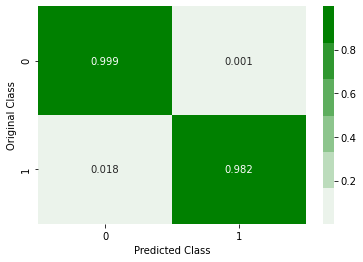

Sum of rows in precision matrix [1. 1.]


In [15]:
# Referred Microsoft Malware detection assignment for this code

# Hyperparameter values for tuning
alpha=[10,50,100]

cv_auc_array=[]

for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,eval_metric='merror')
    x_cfl.fit(X_over,y_over)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_over,y_over)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))

# Printing Performance metric for each value of hyperparameter
for i in range(len(cv_auc_array)):
    print ('AUC Score for n_estimators = ',alpha[i],'is',cv_auc_array[i])

# finding best value of hyperparameter based on performance metric.
best_alpha = np.argmax(cv_auc_array)
    

fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC Score")
plt.show()


# Retraining model with Best hyperparameter value
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],eval_metric='merror')
x_cfl.fit(X_over,y_over)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_over,y_over)
    

# Plotting AUC for train, validation and Test data
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best n_estimators = ', alpha[best_alpha],
       "The Train AUC Score is:",performance_metric(y_train, predict_y[:,1],"Train"))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Validation AUC Score is:",performance_metric(y_cv, predict_y[:,1],"Val"))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Test AUC Score is:",performance_metric(y_test, predict_y[:,1],"Test"))


# Plotting Confusion Matrix
predicted_y =np.argmax(predict_y, axis=1)
print("\n\nTest Confusion, Recall and Precision Matrix will be as follows : \n")
plot_confusion_matrix(y_test, predicted_y)

### 2.6 XGBoost With SMOTE based Sampling of Minority class

<li> This is similar to oversampling. Just that instead of randomly sampling from existing samples, SMOTE algorithm as discussed in abstract will be used to generate new samples.  </li>

In [16]:
# Referred below blog in order to implement SMOTE sampling
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

oversample = imblearn.over_sampling.SMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train)

print("Shape of data before Sampling : ",X_train.shape)
print("Number of Positive points before sampling : ",np.count_nonzero(y_train))
print("Number of Negative points before sampling : ",len(y_over)-np.count_nonzero(y_over))

print("\n\nShape of data after Sampling  : ",X_over.shape)
print("Number of Positive points After sampling : ",np.count_nonzero(y_over))
print("Number of Negative points before sampling : ",len(y_over)-np.count_nonzero(y_over))

Shape of data before Sampling :  (640000, 203)
Number of Positive points before sampling :  14218
Number of Negative points before sampling :  625782


Shape of data after Sampling  :  (1251564, 203)
Number of Positive points After sampling :  625782
Number of Negative points before sampling :  625782


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [10:01<00:00, 200.59s/it]

AUC Score for n_estimators =  10 is 0.9997512693515633
AUC Score for n_estimators =  50 is 0.9998645148035027
AUC Score for n_estimators =  100 is 0.9998818544482629


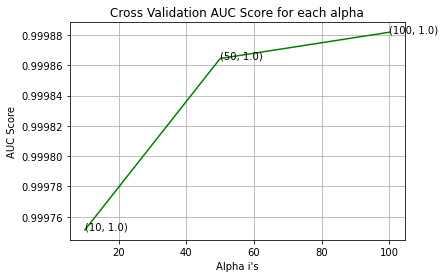

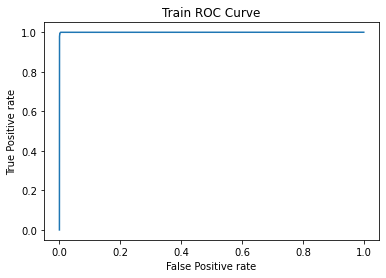

For values of best n_estimators =  100 The Train AUC Score is: 0.9999651305887985


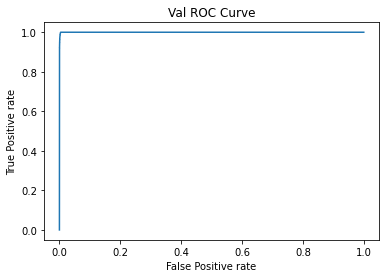

For values of best n_estimators =  100 The Validation AUC Score is: 0.9998818544482629


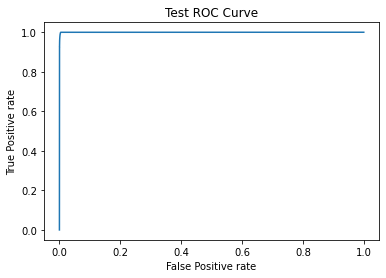

For values of best n_estimators =  100 The Test AUC Score is: 0.9998967048480532


Test Confusion, Recall and Precision Matrix will be as follows : 

Number of misclassified points  0.169
-------------------------------------------------- Confusion matrix --------------------------------------------------


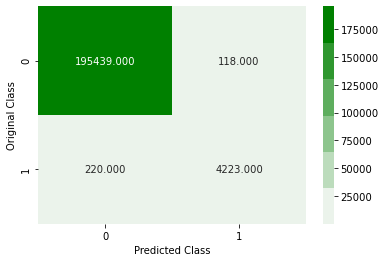

-------------------------------------------------- Precision matrix --------------------------------------------------


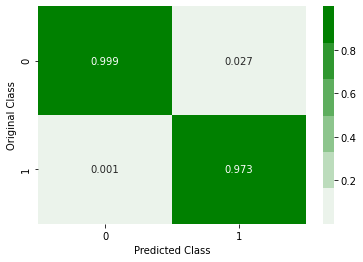

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


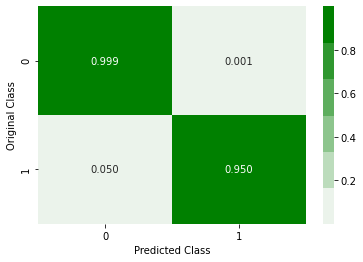

Sum of rows in precision matrix [1. 1.]


In [17]:
# Referred Microsoft Malware detection assignment for this code


# Hyperparameter values for tuning
alpha=[10,50,100]
cv_auc_array=[]


for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,eval_metric='merror')
    x_cfl.fit(X_over,y_over)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_over,y_over)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))

# Printing Performance metric for each value of hyperparameter
for i in range(len(cv_auc_array)):
    print ('AUC Score for n_estimators = ',alpha[i],'is',cv_auc_array[i])

# finding best value of hyperparameter based on performance metric.
best_alpha = np.argmax(cv_auc_array)
    

fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC Score")
plt.show()


# Retraining model with Best hyperparameter value
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],eval_metric='merror')
x_cfl.fit(X_over,y_over)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_over,y_over)


# Plotting AUC for train, validation and Test data
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best n_estimators = ', alpha[best_alpha],
       "The Train AUC Score is:",performance_metric(y_train, predict_y[:,1],"Train"))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Validation AUC Score is:",performance_metric(y_cv, predict_y[:,1],"Val"))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Test AUC Score is:",performance_metric(y_test, predict_y[:,1],"Test"))


# Plotting Confusion Matrix
predicted_y =np.argmax(predict_y, axis=1)
print("\n\nTest Confusion, Recall and Precision Matrix will be as follows : \n")
plot_confusion_matrix(y_test, predicted_y)

### 2.7 Ensemble Models with Sampling

<li> This is one of the techniques found while searching for ways to deal with imbalanced dataset. </li>
<li> Here both oversampling and undersampling will be done for an iteration and a base learner will be trained on this randomly generated subsample. </li>
<li> "n" number of base learners are selected and trained. For predicting probability mean of all the probabilities from base learners is selected as final prediction. </li>

In [24]:
# Referred the sampling code from below blog
# https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

import imblearn

n_estimators = 10      # Number of base learners
n_base_learners = []   # Empty list to store base learner objects
sig_clf = []           # Empty list to store CalibratedClassifierCV objects.

for i in tqdm(range(n_estimators)):
    # Oversampling the minority class
    over = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.1)
    X, y = over.fit_resample(X_train, y_train)
    
    # Undersampling majority class
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
    X, y = under.fit_resample(X, y)
    
    # Training a base learner on this randmoly generated subset of train dataset
    n_base_learners.append(DecisionTreeClassifier())
    n_base_learners[i].fit(X,y)
    sig_clf.append(CalibratedClassifierCV(n_base_learners[i], method="sigmoid"))
    sig_clf[i].fit(X, y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:56<00:00, 23.60s/it]


In [25]:
# Predicting X_test points with all base learners.
y_pred = []
for j in tqdm(range(n_estimators)):
    y_pred.append(sig_clf[j].predict_proba(X_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]


In [26]:
# Getting mean probability obtained for each point with each base learner

predicted_y = []
for i in tqdm(range(X_test.shape[0])):
    temp = []
    for j in range(n_estimators):
        temp.append(y_pred[j][i][1])
    predicted_y.append(np.mean(temp))

100%|███████████████████████████████████████████████████████████████████████| 194736/194736 [00:03<00:00, 53836.06it/s]


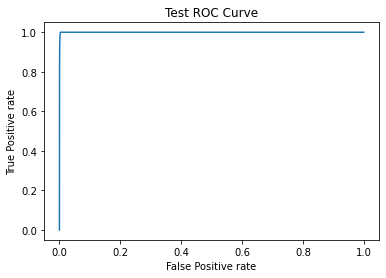

The Test AUC Score is: 0.9997382388716236


Test Confusion, Recall and Precision Matrix will be as follows : 

Number of misclassified points  0.263433571604634
-------------------------------------------------- Confusion matrix --------------------------------------------------


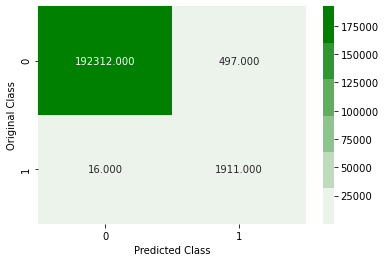

-------------------------------------------------- Precision matrix --------------------------------------------------


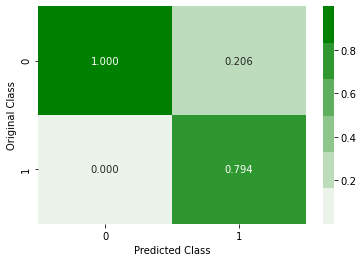

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


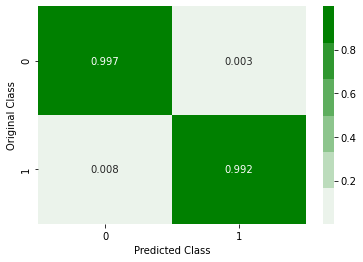

Sum of rows in precision matrix [1. 1.]


In [27]:
print("The Test AUC Score is:",performance_metric(y_test, predicted_y,"Test"))

predicted_y = [1 if i>0.5 else 0 for i in predicted_y]
print("\n\nTest Confusion, Recall and Precision Matrix will be as follows : \n")
plot_confusion_matrix(y_test, predicted_y)

### 2.8 XGBoost model with Important Features only

In [34]:
# Defining Decision tree classifier without max_depth parameter to get feature importance
XGB_clf = XGBClassifier(n_estimators=100,nthread=-1,eval_metric='merror')

XGB_clf.fit(X_train,y_train)   # training on set1 features stored in set1_x_tr variable

# Getting feature importance from trained model
feature_imp = XGB_clf.feature_importances_

In [35]:
# Converting sparse matrices to nd arrays to filter non important features

X_train = X_train.toarray()
X_cv = X_cv.toarray()
X_test = X_test.toarray()


feat_index = []  # empty list to store important feature indices in x_test

for i in range(len(feature_imp)):     # Loop to get indices of important features
    if feature_imp[i] != 0:
        feat_index.append(i)

feat_index = np.array(feat_index) 
        
# Filterting non important features and keeping only important features for train, cv and test datasets
X_train = X_train[:,feat_index]
X_cv = X_cv[:,feat_index]
X_test = X_test[:,feat_index]

In [38]:
print("Shape of Train data after Reducing features based on feature importances : ", X_train.shape)

Shape of Train data after Reducing features based on feature importances :  (640000, 46)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:45<00:00, 75.02s/it]

AUC Score for n_estimators =  10 is 0.9998190784954872
AUC Score for n_estimators =  50 is 0.9998827123479155
AUC Score for n_estimators =  100 is 0.999899580777353


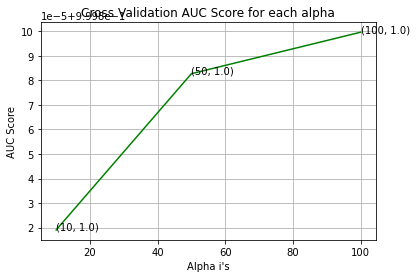

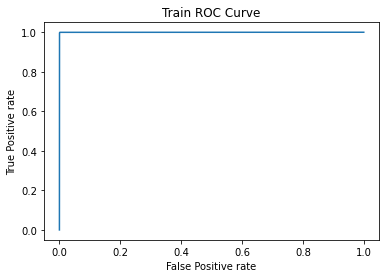

For values of best n_estimators =  100 The Train AUC Score is: 0.9999939164596648


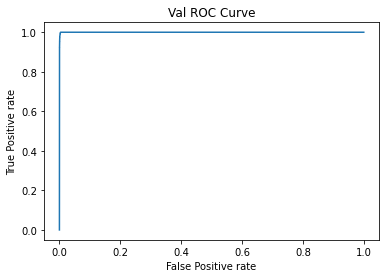

For values of best n_estimators =  100 The Validation AUC Score is: 0.999899580777353


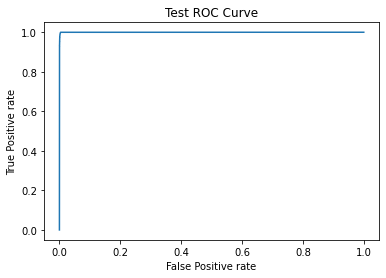

For values of best n_estimators =  100 The Test AUC Score is: 0.9999091901772303


Test Confusion, Recall and Precision Matrix will be as follows : 

Number of misclassified points  0.166
-------------------------------------------------- Confusion matrix --------------------------------------------------


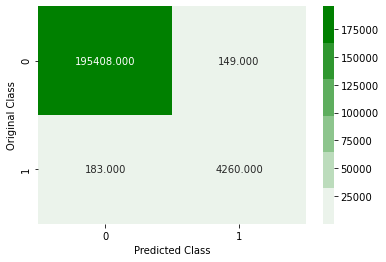

-------------------------------------------------- Precision matrix --------------------------------------------------


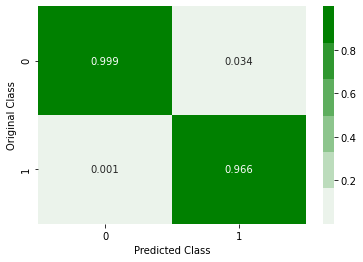

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


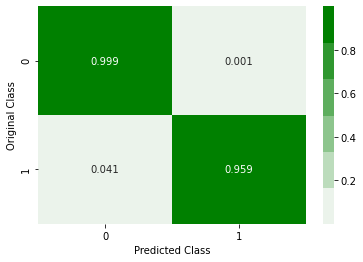

Sum of rows in precision matrix [1. 1.]


In [37]:
# Referred Microsoft Malware detection assignment for this code


# Hyperparameter values for tuning
alpha=[10,50,100]
cv_auc_array=[]


for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,eval_metric='merror')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))

# Printing Performance metric for each value of hyperparameter
for i in range(len(cv_auc_array)):
    print ('AUC Score for n_estimators = ',alpha[i],'is',cv_auc_array[i])

# finding best value of hyperparameter based on performance metric.
best_alpha = np.argmax(cv_auc_array)
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC Score")
plt.show()


# Retraining model with Best hyperparameter value
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],eval_metric='merror')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)


# Plotting AUC for train, validation and Test data 
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best n_estimators = ', alpha[best_alpha],
       "The Train AUC Score is:",performance_metric(y_train, predict_y[:,1],"Train"))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Validation AUC Score is:",performance_metric(y_cv, predict_y[:,1],"Val"))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best n_estimators = ', alpha[best_alpha],
      "The Test AUC Score is:",performance_metric(y_test, predict_y[:,1],"Test"))



# Plotting Confusion Matrix
predicted_y =np.argmax(predict_y, axis=1)
print("\n\nTest Confusion, Recall and Precision Matrix will be as follows : \n")
plot_confusion_matrix(y_test, predicted_y)

# 3. Conclusions  & Observations

### 3.1 Observed Results

<table>
    <tr>
        <td>  <b>Sr. No.</b> </td>
        <td> <b>Model </b></td>
        <td> <b>Test AUC Score </b></td>
        <td> <b>TP </b></td>
        <td> <b>FP </b></td>
        <td> <b>TN </b></td>
        <td> <b>FN </b></td>
        <td> <b>Precision for both classes </b></td>
        <td> <b> Recall for both classes</b></td>
        <td> <b> Misclassified points Percentage </b> </td>
    </tr>
     <tr>
        <td>  1 </td>
        <td> Random Model </td>
        <td> 0.50347711871395</td>
        <td> 2248 </td>
        <td> 97709 </td>
        <td> 97848 </td>
        <td> 2195 </td>
         <td> <li> Class 0 : 0.978</li>
             <li> Class 1 : 0.022 </li>
         </td>
        <td> <li> Class 0 : 0.500</li>
             <li> Class 1 : 0.506 </li>
         </td>
         <td> 49.952 </td>
    </tr>
    <tr>
        <td>  2 </td>
        <td> Logistic Regression </td>
        <td> 0.9994589264844425  </td>
        <td> 4331 </td>
        <td> 589 </td>
        <td> 194968 </td>
        <td> 112 </td>
         <td> <li> Class 0 : 0.999</li>
             <li> Class 1 :  0.880</li>
         </td>
        <td> <li> Class 0 : 0.997</li>
             <li> Class 1 : 0.975</li>
         </td>
        <td> 0.3505 </td>
    </tr>
    <tr>
        <td>  3 </td>
        <td> Random Forest Classifier </td>
        <td> 0.9998983299664896  </td>
        <td> 4272 </td>
        <td> 176 </td>
        <td> 195381 </td>
        <td> 171 </td>
         <td> <li> Class 0 : 0.999</li>
             <li> Class 1 :  0.960</li>
         </td>
        <td> <li> Class 0 : 0.999</li>
             <li> Class 1 : 0.962</li>
         </td>
        <td> 0.1735 </td>
    </tr>
    <tr>
        <td>  4 </td>
        <td> XgBoost Classifier </td>
        <td> 0.999907101232498  </td>
        <td> 4259 </td>
        <td> 149 </td>
        <td> 195408 </td>
        <td> 184 </td>
         <td> <li> Class 0 : 0.999</li>
             <li> Class 1 :  0.966</li>
         </td>
        <td> <li> Class 0 : 0.999</li>
             <li> Class 1 : 0.959</li>
         </td>
        <td> 0.1665 </td>
    </tr>
    <tr>
        <td>  5 </td>
        <td> XGBoost With Oversampling of Minority class </td>
        <td> 0.9998982603349985  </td>
        <td> 4361 </td>
        <td> 288 </td>
        <td> 195269 </td>
        <td> 82 </td>
         <td> <li> Class 0 : 1.000</li>
             <li> Class 1 :  0.938</li>
         </td>
        <td> <li> Class 0 : 0.999</li>
             <li> Class 1 : 0.982</li>
         </td>
        <td> 0.185 </td>
    </tr>
    <tr>
        <td>  6 </td>
        <td> XGBoost With SMOTE based Sampling of Minority class </td>
        <td> 0.9998967048480532  </td>
        <td> 4223 </td>
        <td> 118 </td>
        <td> 195439 </td>
        <td> 220 </td>
         <td> <li> Class 0 : 0.999</li>
             <li> Class 1 :  0.973</li>
         </td>
        <td> <li> Class 0 : 0.999</li>
             <li> Class 1 : 0.950</li>
         </td>
        <td> 0.169 </td>
    </tr>
    <tr>
        <td>  7 </td>
        <td> Ensemble Models with Sampling </td>
        <td> 0.999827820888437  </td>
        <td> 4422 </td>
        <td> 624 </td>
        <td> 194933 </td>
        <td> 21 </td>
         <td> <li> Class 0 : 1.000</li>
             <li> Class 1 :  0.876</li>
         </td>
        <td> <li> Class 0 : 0.997</li>
             <li> Class 1 : 0.995</li>
         </td>
        <td> 0.3225 </td>
    </tr>
    <tr>
        <td>  8 </td>
        <td> XGBoost model with Important Features only </td>
        <td> 0.9999091901772303  </td>
        <td> 4260 </td>
        <td> 149 </td>
        <td> 195408 </td>
        <td> 183 </td>
         <td> <li> Class 0 : 0.999</li>
             <li> Class 1 :  0.966</li>
         </td>
        <td> <li> Class 0 : 0.999</li>
             <li> Class 1 : 0.959</li>
         </td>
        <td> 0.0.166 </td>
    </tr>
</table>

### 3.2 Conclusions

<li> We have task of identifying the network attacks where the cost of misclassifying an any network traffic i very high. That to if any attack is misclassified then that is unacceptable. </li>
<li> In test data 4443 positive or attack points are there. Hence The model which can predict maximum number of these attack points should be our priority. That means the prediction recall for class 1 should be as high as possible. </li>
<li> In this notebook, 8 models were tested with random model as a base model, although all the models tested performed way better than random model, our priority is to predict maximum number of attack points. </li>
<li> Since there is an imbalance in dataset, training with existing data was giving a good performance but still the True positive number was not exeeding 4400 mark ( since we have 4443 attack data points in test data.) </li>
<li> Few improvements were made to improve the results further, first method was to Oversample the minority class and train the XGBoost model with the obtained data. The number of TP were improved. </li>
<li> Second method was to generate minority class samples with SMOTE algorithm (Synthetic Minority Oversampling technique) but the number of TP did not improve. </li>
<li> Third method was to train "n" number of base learners on small balanced samples of the training dataset and after training each base learner, with CalibratedClassifierCV prediction probabilities are obtained from each base learner and an average is taken of these probabilities for final prediction. With this method highest number of true positives were obtained, hence recall value increased to 99.5% which is highest among all the trained models. </li>
<li> Due to computation limitations, hyperparameter tuning could not be performed for this third method, but with a optimised hyperparameters, the TP number can be brought near actual number of positive points. </li>
<li> The last XGBoostClassifier model (2.8) with feature selection was to demonstrate that we can reduce number of features by considering feature importances of trained models. </li>

### 4. Saving Best Model

In [8]:
data = pd.read_csv("final_data.csv",nrows=1500000)

# Separating Class label and features
X_train = data.drop(['Label','attack_cat'],axis=1)
y_train = data['Label']

# Dictionary to get the index of features from the column names
ref_dict = {}
temp = data.columns
for i in range(len(temp)):
    ref_dict[temp[i]] = i
    


# Preprocessing all the variables

scalars = {}    # empty dictionary to store all sclar objects
encoders = {}   # empty dictionary to store all encoder objects

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


# Categorical Features
onehotencoder = OneHotEncoder(handle_unknown='ignore')
proto_train = onehotencoder.fit_transform(X_train['proto'].values.reshape(-1,1))
encoders['proto'] = onehotencoder


onehotencoder = OneHotEncoder(handle_unknown='ignore')
state_train = onehotencoder.fit_transform(X_train['state'].values.reshape(-1,1))
encoders['state'] = onehotencoder


onehotencoder = OneHotEncoder(handle_unknown='ignore')
service_train = onehotencoder.fit_transform(X_train['service'].values.reshape(-1,1))
encoders['service'] = onehotencoder


onehotencoder = OneHotEncoder(handle_unknown='ignore')
is_sm_ips_ports_train = onehotencoder.fit_transform(X_train['is_sm_ips_ports'].values.reshape(-1,1))
encoders['is_sm_ips_ports'] = onehotencoder


onehotencoder = OneHotEncoder(handle_unknown='ignore')
ct_state_ttl_train = onehotencoder.fit_transform(X_train['ct_state_ttl'].values.reshape(-1,1))
encoders['ct_state_ttl'] = onehotencoder



# Encoding Numerical Features
scaler = StandardScaler()
sport_train = scaler.fit_transform(X_train['sport'].values.reshape(-1,1))
scalars['sport'] = scaler


scaler = StandardScaler()
dsport_train = scaler.fit_transform(X_train['dsport'].values.reshape(-1,1))
scalars['dsport'] = scaler


scaler = StandardScaler()
dur_train = scaler.fit_transform(X_train['dur'].values.reshape(-1,1))
scalars['dur'] = scaler


scaler = StandardScaler()
sbytes_train = scaler.fit_transform(X_train['sbytes'].values.reshape(-1,1))
scalars['sbytes'] = scaler



scaler = StandardScaler()
dbytes_train = scaler.fit_transform(X_train['dbytes'].values.reshape(-1,1))
scalars['dbytes'] = scaler



scaler = StandardScaler()
sttl_train = scaler.fit_transform(X_train['sttl'].values.reshape(-1,1))
scalars['sttl'] = scaler



scaler = StandardScaler()
dttl_train = scaler.fit_transform(X_train['dttl'].values.reshape(-1,1))
scalars['dttl'] = scaler


scaler = StandardScaler()
sloss_train = scaler.fit_transform(X_train['sloss'].values.reshape(-1,1))
scalars['sloss'] = scaler



scaler = StandardScaler()
dloss_train = scaler.fit_transform(X_train['dloss'].values.reshape(-1,1))
scalars['dloss'] = scaler



scaler = StandardScaler()
Sload_train = scaler.fit_transform(X_train['Sload'].values.reshape(-1,1))
scalars['Sload'] = scaler



scaler = StandardScaler()
Dload_train = scaler.fit_transform(X_train['Dload'].values.reshape(-1,1))
scalars['Dload'] = scaler


scaler = StandardScaler()
Spkts_train = scaler.fit_transform(X_train['Spkts'].values.reshape(-1,1))
scalars['Spkts'] = scaler



scaler = StandardScaler()
Dpkts_train = scaler.fit_transform(X_train['Dpkts'].values.reshape(-1,1))
scalars['Dpkts'] = scaler



scaler = StandardScaler()
swin_train = scaler.fit_transform(X_train['swin'].values.reshape(-1,1))
scalars['swin'] = scaler



scaler = StandardScaler()
dwin_train = scaler.fit_transform(X_train['dwin'].values.reshape(-1,1))
scalars['dwin'] = scaler


scaler = StandardScaler()
stcpb_train = scaler.fit_transform(X_train['stcpb'].values.reshape(-1,1))
scalars['stcpb'] = scaler


scaler = StandardScaler()
dtcpb_train = scaler.fit_transform(X_train['dtcpb'].values.reshape(-1,1))
scalars['dtcpb'] = scaler


scaler = StandardScaler()
smeansz_train = scaler.fit_transform(X_train['smeansz'].values.reshape(-1,1))
scalars['smeansz'] = scaler


scaler = StandardScaler()
dmeansz_train = scaler.fit_transform(X_train['dmeansz'].values.reshape(-1,1))
scalars['dmeansz'] = scaler



scaler = StandardScaler()
trans_depth_train = scaler.fit_transform(X_train['trans_depth'].values.reshape(-1,1))
scalars['trans_depth'] = scaler



scaler = StandardScaler()
res_bdy_len_train = scaler.fit_transform(X_train['res_bdy_len'].values.reshape(-1,1))
scalars['res_bdy_len'] = scaler



scaler = StandardScaler()
Sjit_train = scaler.fit_transform(X_train['Sjit'].values.reshape(-1,1))
scalars['Sjit'] = scaler



scaler = StandardScaler()
Djit_train = scaler.fit_transform(X_train['Djit'].values.reshape(-1,1))
scalars['Djit'] = scaler



scaler = StandardScaler()
Sintpkt_train = scaler.fit_transform(X_train['Sintpkt'].values.reshape(-1,1))
scalars['Sintpkt'] = scaler


scaler = StandardScaler()
Dintpkt_train = scaler.fit_transform(X_train['Dintpkt'].values.reshape(-1,1))
scalars['Dintpkt'] = scaler


scaler = StandardScaler()
tcprtt_train = scaler.fit_transform(X_train['tcprtt'].values.reshape(-1,1))
scalars['tcprtt'] = scaler


scaler = StandardScaler()
synack_train = scaler.fit_transform(X_train['synack'].values.reshape(-1,1))
scalars['synack'] = scaler


scaler = StandardScaler()
ackdat_train = scaler.fit_transform(X_train['ackdat'].values.reshape(-1,1))
scalars['ackdat'] = scaler


scaler = StandardScaler()
ct_srv_src_train = scaler.fit_transform(X_train['ct_srv_src'].values.reshape(-1,1))
scalars['ct_srv_src'] = scaler


scaler = StandardScaler()
ct_srv_dst_train = scaler.fit_transform(X_train['ct_srv_dst'].values.reshape(-1,1))
scalars['ct_srv_dst'] = scaler


scaler = StandardScaler()
ct_dst_ltm_train = scaler.fit_transform(X_train['ct_dst_ltm'].values.reshape(-1,1))
scalars['ct_dst_ltm'] = scaler


scaler = StandardScaler()
ct_src_ltm_train = scaler.fit_transform(X_train['ct_src_ltm'].values.reshape(-1,1))
scalars['ct_src_ltm'] = scaler


scaler = StandardScaler()
ct_src_dport_ltm_train = scaler.fit_transform(X_train['ct_src_dport_ltm'].values.reshape(-1,1))
scalars['ct_src_dport_ltm'] = scaler


scaler = StandardScaler()
ct_dst_sport_ltm_train = scaler.fit_transform(X_train['ct_dst_sport_ltm'].values.reshape(-1,1))
scalars['ct_dst_sport_ltm'] = scaler


# Stacking all the generated features to train the model
X_train = hstack((proto_train,state_train,service_train,is_sm_ips_ports_train,ct_state_ttl_train,
                        sport_train,dsport_train,dur_train,sbytes_train,dbytes_train,sttl_train,dttl_train,
                        sloss_train,dloss_train,Sload_train,Dload_train,Spkts_train,Dpkts_train,swin_train,
                        dwin_train,stcpb_train,dtcpb_train,smeansz_train,dmeansz_train,trans_depth_train,
                        res_bdy_len_train,Sjit_train,Djit_train,Sintpkt_train,Dintpkt_train,
                        tcprtt_train,synack_train,ackdat_train,ct_srv_src_train,ct_srv_dst_train,ct_dst_ltm_train,
                        ct_src_ltm_train,ct_src_ltm_train,ct_src_dport_ltm_train,ct_dst_sport_ltm_train)).tocsr()

# saving the dictionaries in a list to store it in a pickle file
preprocessing = [encoders,scalars]


# Referred the sampling code from below blog
# https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

import imblearn

n_estimators = 10      # Number of base learners
n_base_learners = []   # Empty list to store base learner objects
sig_clf = []           # Empty list to store CalibratedClassifierCV objects.

for i in tqdm(range(n_estimators)):
    # Oversampling the minority class
    over = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.1)
    X, y = over.fit_resample(X_train, y_train)
    
    # Undersampling majority class
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
    X, y = under.fit_resample(X, y)
    
    # Training a base learner on this randmoly generated subset of train dataset
    n_base_learners.append(DecisionTreeClassifier())
    n_base_learners[i].fit(X,y)
    sig_clf.append(CalibratedClassifierCV(n_base_learners[i], method="sigmoid"))
    sig_clf[i].fit(X, y)
    
# Creating one list with all the objects so that with one file we can get all the details regarding model.
all_saved_data = [ref_dict,preprocessing,sig_clf]
pickle.dump(all_saved_data,open("all_saved_data.pkl","wb"))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:12<00:00, 79.30s/it]
